In [101]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask import delayed, compute
from typing import Tuple

BED_FILE = "../../real-data/10k_sorted.bed"
OUT_DIR = "./"
DEPTH = 25
READ_VARIATION = 0.15
BATCH_SIZE = 100
SIGMA = 5

rng = np.random.default_rng()

In [102]:
def simulate_reads_batch_uniform(props: list) -> list[Tuple[int, int, float]]:
    results = []

    for prop in props:
        num_reads = int(DEPTH + DEPTH * READ_VARIATION * (2 * np.random.rand() - 1))

        random_values = 100 * np.random.rand(num_reads)
        mc_count = np.sum(random_values < prop, dtype=np.int32)
        uc_count = num_reads - mc_count

        sim_prop = 100 * mc_count / (mc_count + uc_count)

        results.append((uc_count, mc_count, sim_prop))

    return results


def simulate_reads_batch_normal(batch: Tuple[list[float], list[int]], mu: float=0, sigma: float=0.3) -> list[Tuple[int, int, float]]:
    results = []

    for prop, z_score in batch:
        num_reads = int(z_score * SIGMA + DEPTH)

        # random_values = 100 * rng.normal(mu, sigma, true_num_reads)
        random_values = 100 * rng.uniform(size=num_reads)
        mc_count = np.sum(random_values < prop, dtype=np.int32)
        uc_count = num_reads - mc_count

        sim_prop = 100 * mc_count / (mc_count + uc_count)

        results.append((uc_count, mc_count, sim_prop))

    return results


In [103]:
col_labels = ["chr", "start", "end", "uc", "mc", "prop"]
bed_data = pd.read_csv(BED_FILE, sep="\t", names=col_labels, header=None)
props = bed_data["prop"].tolist()
original_read_depths = (bed_data["uc"] + bed_data["mc"]).tolist()

In [104]:
sim_bed_data_uniform = bed_data.copy()
batches_uniform = [props[i : i + BATCH_SIZE] for i in range(0, len(props), BATCH_SIZE)]

delayed_results_uniform = [delayed(simulate_reads_batch_uniform)(batch) for batch in batches_uniform]

batch_results_uniform = compute(*delayed_results_uniform)

sim_reads_uniform = [result for batch in batch_results_uniform for result in batch]

for row, (uc, mc, pm) in enumerate(sim_reads_uniform):
    sim_bed_data_uniform.at[row, "uc"] = uc
    sim_bed_data_uniform.at[row, "mc"] = mc
    sim_bed_data_uniform.at[row, "prop"] = pm

simulated_read_depths_uniform = (sim_bed_data_uniform["uc"] + sim_bed_data_uniform["mc"]).tolist()

In [105]:
sim_bed_data_normal = bed_data.copy()

mean_read_depth = np.mean(original_read_depths)
std_read_depth = np.std(original_read_depths)
z_scores = (np.array(original_read_depths) - mean_read_depth) / std_read_depth

batches_normal = [list(zip(props[i : i + BATCH_SIZE], z_scores[i : i + BATCH_SIZE])) for i in range(0, len(props), BATCH_SIZE)]

# delayed_results_normal = [delayed(simulate_reads_batch_normal)(batch) for batch in batches_normal]
# prop_batches_normal = [props[i : i + BATCH_SIZE] for i in range(0, len(props), BATCH_SIZE)]
# read_count_batches = [original_read_depths[i : i + BATCH_SIZE] for i in range(0, len(original_read_depths), BATCH_SIZE)]


# delayed_results_normal = [delayed(simulate_reads_batch_normal)(prop_batches_normal, read_count_batch) for prop_batch, read_count_batch in zip(prop_batches_normal, read_count_batches)]
delayed_results_normal = [delayed(simulate_reads_batch_normal)(batch) for batch in batches_normal]

batch_results_normal = compute(*delayed_results_normal)

sim_reads_normal = [result for batch in batch_results_normal for result in batch]

for row, (uc, mc, pm) in enumerate(sim_reads_normal):
    sim_bed_data_normal.at[row, "uc"] = uc
    sim_bed_data_normal.at[row, "mc"] = mc
    sim_bed_data_normal.at[row, "prop"] = pm

simulated_read_depths_normal = (sim_bed_data_normal["uc"] + sim_bed_data_normal["mc"]).tolist()

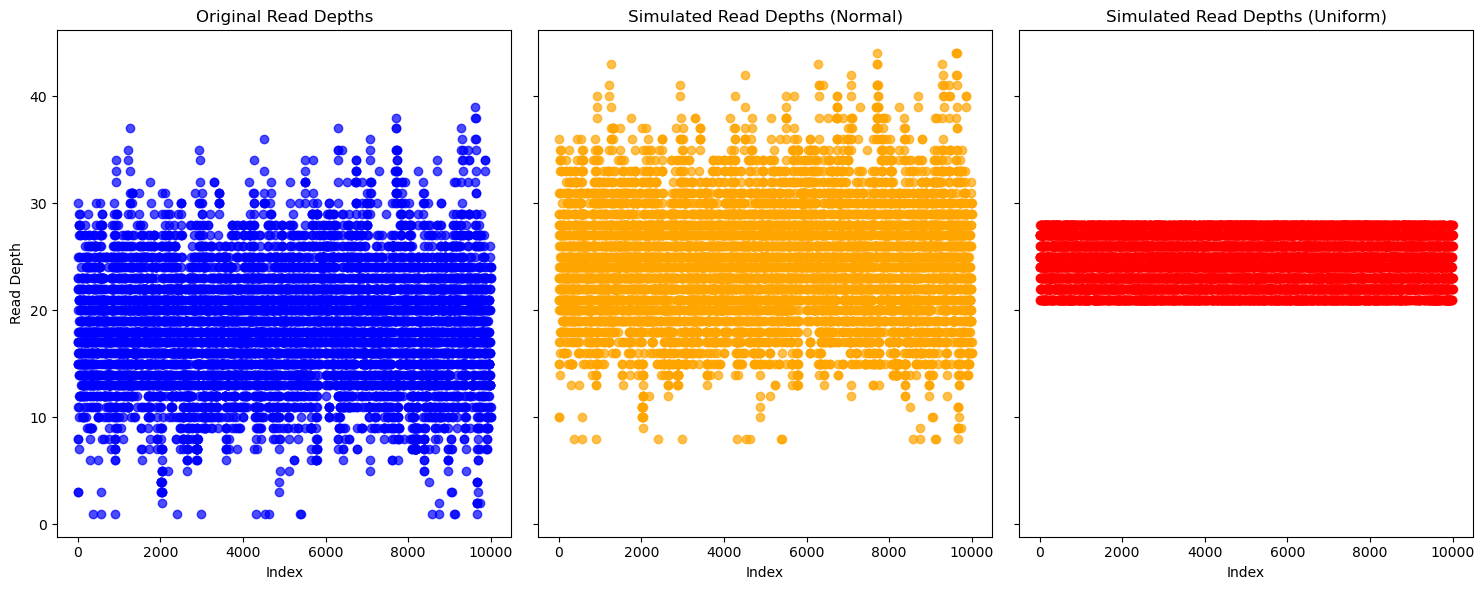

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

axes[0].scatter(range(len(original_read_depths)), original_read_depths, color='blue', alpha=0.7)
axes[0].set_title("Original Read Depths")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Read Depth")

axes[1].scatter(range(len(simulated_read_depths_normal)), simulated_read_depths_normal, color='orange', alpha=0.7)
axes[1].set_title("Simulated Read Depths (Normal)")
axes[1].set_xlabel("Index")

axes[2].scatter(range(len(simulated_read_depths_uniform)), simulated_read_depths_uniform, color='red', alpha=0.7)
axes[2].set_title("Simulated Read Depths (Uniform)")
axes[2].set_xlabel("Index")

plt.tight_layout()
plt.show()

In [107]:
sim_bed_data_normal.to_csv("test_norm.csv", sep="\t", index=False, header=False)